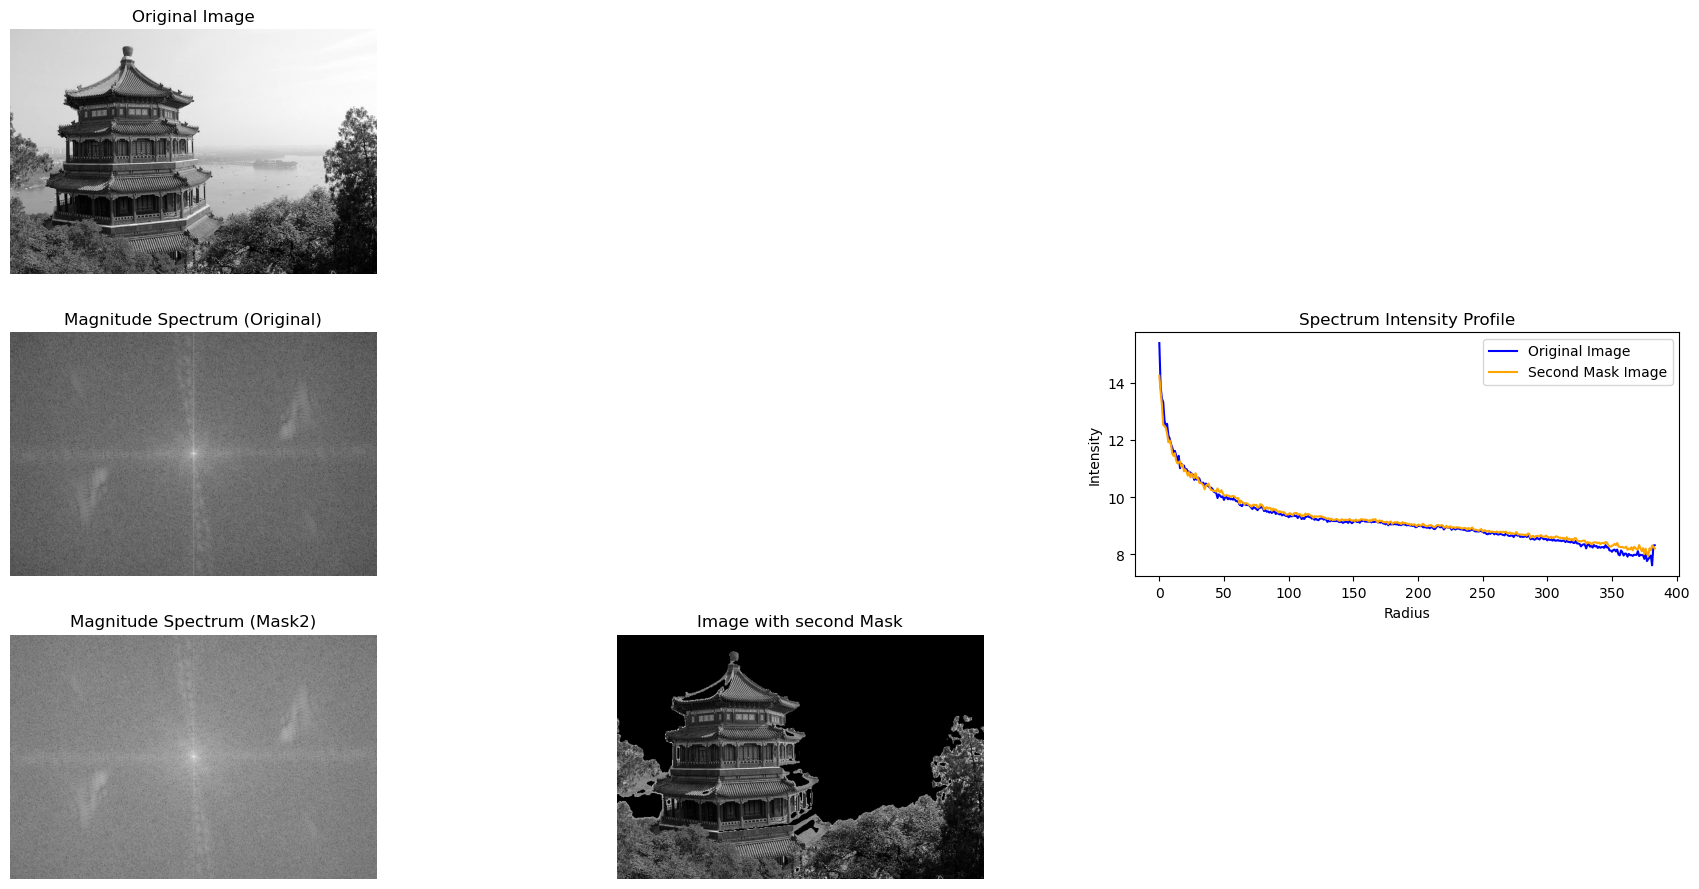

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, util, filters
from sklearn.datasets import load_sample_image
from scipy.ndimage import gaussian_filter

# Load a sample image from scikit-learn (e.g., "china" or "flower")

image = load_sample_image('china.jpg')# You can also use 'china.jpg'
image_gray = np.mean(image, axis=2).astype(np.uint8)  # Convert to grayscale by averaging the RGB channels

# Perform Fourier Transformation
def perform_fft(image):
    """Perform Fourier Transformation and shift the zero frequency component to the center."""
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)
    return f_transform_shifted

def calculate_magnitude_spectrum(f_transform_shifted):
    """Compute the magnitude spectrum and apply logarithmic scaling."""
    magnitude_spectrum = np.abs(f_transform_shifted)
    log_magnitude_spectrum = np.log1p(magnitude_spectrum)
    return log_magnitude_spectrum

# Generate a circular mask
def create_circular_mask(shape, radius=None):
    """Create a circular mask."""
    center = np.array(shape) // 2
    Y, X = np.ogrid[:shape[0], :shape[1]]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
    if radius is None:
        radius = min(center)
    mask = dist_from_center <= radius
    return mask

# Compute radial profile
def radial_profile(image):
    """Compute the radial profile of an image."""
    center = np.array(image.shape) // 2
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]
    radii = np.sqrt((X - center[1])**2 + (Y - center[0])**2)
    radii = radii.astype(np.int64)
    
    tbin = np.bincount(radii.ravel(), image.ravel())
    nr = np.bincount(radii.ravel())
    radial_prof = tbin / nr
    radial_prof = radial_prof[1:]  # Skip the zero radius
    
    return radial_prof

# Perform FFT and compute magnitude spectrum for the original image
f_transform_original = perform_fft(image_gray)
log_magnitude_spectrum_original = calculate_magnitude_spectrum(f_transform_original)


#==================  MASK 1 ====================
# Create and apply circular mask
radius = min(image_gray.shape) // 4
mask = create_circular_mask(image_gray.shape, radius)
masked_image = np.where(mask, image_gray, 0)

# Perform FFT and compute magnitude spectrum for the masked image
f_transform_masked = perform_fft(masked_image)
log_magnitude_spectrum_masked = calculate_magnitude_spectrum(f_transform_masked)


#==================  MASK 2 ====================
# Create and apply circular mask
# radius2 = min(image_gray.shape) // 6 + 20
# mask2 = create_circular_mask(image_gray.shape, radius2)
# masked_image2 = np.where(mask2, image_gray, 0)
def create_circular_mask(shape, radius, shift_x=0, shift_y=0):
    h, w = shape[:2]
    center = (h // 2 + shift_y, w // 2 + shift_x)  # Apply shifts to the default center

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)

    mask = dist_from_center <= radius
    return mask

# Parameters for shifting
shift_x = -90  # Horizontal shift (positive to the right, negative to the left)
shift_y = 0    # Vertical shift (positive downwards, negative upwards)

# Use the editable shifts in create_circular_mask
radius2 = min(image_gray.shape) // 4
mask2 = create_circular_mask(image_gray.shape, radius2, shift_x, shift_y)


# Apply Gaussian filter to smooth the image (optional, for better segmentation)
smoothed_image = gaussian_filter(image_gray, sigma=2)

# Apply global thresholding to create a binary mask
threshold_value = filters.threshold_otsu(smoothed_image)  # Using Otsu's method to determine the threshold
segmented_mask = smoothed_image > threshold_value  # Binary mask


masked_image2 = np.where(segmented_mask, 0, image_gray)
# Perform FFT and compute magnitude spectrum for the mask
f_transform_mask2 = perform_fft(masked_image2)
log_magnitude_spectrum_masked2 = calculate_magnitude_spectrum(f_transform_mask2)




#================= Radial Intensities ===========
# Calculate radial profiles
radial_intensity_original = radial_profile(log_magnitude_spectrum_original)
radial_intensity_masked = radial_profile(log_magnitude_spectrum_masked)
radial_intensity_masked2 = radial_profile(log_magnitude_spectrum_masked2)

# Plot the results
plt.figure(figsize=(18, 9))

# Original image
plt.subplot(3, 3, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Magnitude Spectrum of Original Image
plt.subplot(3, 3, 4)
plt.imshow(log_magnitude_spectrum_original, cmap='gray')
plt.title('Magnitude Spectrum (Original)')
plt.axis('off')

# Spectrum Intensity Profile (Original)
plt.subplot(3, 3, 6)
plt.plot(radial_intensity_original, label='Original Image', color='blue')
plt.title('Spectrum Intensity Profile')
plt.xlabel('Radius')
plt.ylabel('Intensity')
plt.legend()


# Spectrum Intensity Profile (Masked)
plt.plot(radial_intensity_masked2, label='Second Mask Image', color='orange')
plt.legend()


# # Magnitude Spectrum of Mask
# plt.subplot(3, 3, 7)
# plt.imshow(log_magnitude_spectrum_mask, cmap='gray')
# plt.title('Magnitude Spectrum (Mask)')
# plt.axis('off')

# Magnitude Spectrum of Mask
plt.subplot(3, 3, 7)
plt.imshow(log_magnitude_spectrum_masked2, cmap='gray')
plt.title('Magnitude Spectrum (Mask2)')
plt.axis('off')

# Masked image
plt.subplot(3, 3, 8)
plt.imshow(masked_image2, cmap='gray')
plt.title('Image with second Mask')
plt.axis('off')

plt.tight_layout()
plt.show()
